<a href="https://colab.research.google.com/github/ktaniguc/RNNSongGenerator/blob/main/LstmSongGen_wDataAug_pytorch_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 使い方
- 数個下のセルの↓↓の部分で自分のgoogle drive に正しくマウントしてください
  ```sh
  from google.colab import drive
  drive.mount('/content/drive/')
  !cd "/content/drive/MyDrive/"
  ```
- 数個下のセルの↓↓の部分を正しく設定してください
  ```python
  #IN/OUT/出力結果/ハイパーパラメータの名前を設定
  TRAIN_DIR="/content/drive/MyDrive/Colab_Notebooks/songs/train/" #学習用midi データ置き場(評価用置き場はなくしました。勝手に学習用から評価用のデータを一部もぎ取って確保します。)
  DIR = "/content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v4/" #モデルやら生成物やらの出力先。予め作ってください。
  ```
- 上２つさえ設定すればモデルの作成まで本ipynbで行えます(多分)
- 本ipynb で作成したモデルから曲を生成するのは別ファイル(predict_LstmSongGen_pytorch_v2.ipynb)で行います。

### 注意点
- 意味不明なこと言っている&間違った言葉の使い方をしている可能性大

### 要改善点(反省点)
- dataaugmentation の前に
  - dropout など、過学習防止の策を取る
  - keras のCuDNNでは拡張性に乏しい(dropoutの実装がないなど)→pytorchに乗り換える
 - LSTM とは言えども、それほど長いメロディーは覚えられないのでは
  - batch でもっと細かく切ってみる?一旦曲ごとに分ける
  - http://mitaka.boo.jp/articles/article12
- data augmentation を行うに当たり(移調+1~+11)、大量のリソースが必要
  - pytorch にすればバッチ処理可能？
- 参考
  - [LSTMによる自動作曲システムの構築] file:///Users/taniguchikouhei/OneDrive/downloads/48146440-1.pdf
  - [PyTorchを使ってLSTMモデルを実装する―RNNで文章生成〈８〉]http://mitaka.boo.jp/articles/article11
  - [PyTorchを使ってLSTMで文章分類を実装してみた]https://qiita.com/m__k/items/841950a57a0d7ff05506
  - [PyTorchのRNNクラスを使って文章を生成してみよう]https://atmarkit.itmedia.co.jp/ait/articles/2103/26/news026.html
  - [【Pytorch入門】ニュース記事で文章生成がしたい]https://qiita.com/hcpmiyuki/items/c6afc037518542cfe410

### 改善した点
- embedding 層、batch 処理、bptt(学習の文章長を制限) の導入
- 移調のdata augmentation を行えるように
- dropout層追加
- 20epoch ごとにmodel 保存、midi 生成ができるように(更新アリ)

### 更新
- 08/24
  - 何故かBATCH_SIZE が2以上ではうまく行かない
    - 修正完了(しんどい...)
  - 音楽生成の部分は他のipynb に任せる
- 8/25
  - 検証データをちゃんと設け、perplexity で精度を評価できるように
    - どのepoch のモデルが良いかを見るため。
  - train, validation 用に自動でデータを分割
    - defuault では0.95:0.05 (どーせ検証といえど聴かんとわからんから申し訳程度に)
  - bug (needless option(remove batch_first=True))直した
  - 20epoch ごとにモデルの保存ではなく、validation data を用いたperplexity の値が改善されたときに保存するように変更

## setup

In [10]:
#!pip install tqdm
!pip install mido keras torch
#!pip install -U torchtext

In [11]:
from google.colab import drive
drive.mount('/content/drive/')
!cd "/content/drive/MyDrive/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
#IN/OUT/出力結果/ハイパーパラメータの名前を設定
TRAIN_DIR="/content/drive/MyDrive/Colab_Notebooks/songs/train/" #学習用midi データ置き場(評価用はないっす)
BPM="150"
augment=12 #data augumentation でnote をどこまで移調するか。+1で半音。
argstep=1 #移調のstep
DIR = "/content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v5/" #モデルやら生成物やらの出力先

!mkdir -p {DIR + "train_txt/"} #学習用データ midi をtext に変換したものを保管
!mkdir -p {DIR + "result_txt/"} #予測した結果をtxt で保管
!mkdir -p {DIR + "result_mid/"} #予測結果txt をmidi に変換して保管
!mkdir -p {DIR + "output_model/"}
TRAIN_TXT_DIR = DIR + "train_txt/" #学習用データ midi をtext に変換したものを保管
RESULT_TXT_DIR = DIR + "result_txt/" #予測した結果をtxt で保管
RESULT_MIDI_DIR = DIR + "result_mid/" #予測結果txt をmidi に変換して保管
OUTPUT_MODEL_DIR = DIR + "output_model/"

BATCH_SIZE=20 #ミニバッチサイズ
BPTT_LEN = 140 #text とtarget の長さ 700(BPM=120)で30秒くらい。
EMBEDDING_DIM = 512 #embedding 層
HIDDEN_DIM = 512 #隠れ層
DROPOUT = 0.5
max_norm = 0.25 #勾配クリッピング
epochs = 50

In [13]:
#https://qiita.com/ysit/items/a601cb59523cc1961556
#鬼のimport祭り
import mido
from mido import Message, MidiFile
from pathlib import Path
import sys, os
import random
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from tensorflow import keras
import numpy as np
import mido
from mido import Message, MidiFile, MidiTrack, MetaMessage
import sys
import matplotlib.pyplot as plt
import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1.9.0+cu102 True


## main

In [14]:
#cuda であーだこーだ怒られたときの対処セル。いらないかも。
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!ls -d /usr/local/cuda-*
!which nvcc
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.0/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.0/lib64:{ld}"
!nvcc --version
##!pip install torch==1.8.0
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#assert torch.__version__.startswith("1.8")

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
1.9.0+cu102
/usr/local/cuda-10.0  /usr/local/cuda-10.1  /usr/local/cuda-11.0
/usr/local/cuda/bin/nvcc
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


mid2txt.py

In [15]:
# 各トラック毎の全メッセージを表示する
def dump_track(track_obj):
    for msg in track_obj:
        print(msg)

# 全トラックの全メッセージをトラック毎に表示する
def dump_smf(midi_obj):
    for i, track in enumerate(midi_obj.tracks):
        print(f"Track {i}: {track.name}")
        dump_track(track)

def note_on_off(msg_type):
  if msg_type == "note_on":
    return "1_"
  else:
    return "0_"

pathlist = Path(TRAIN_DIR).glob('**/*.[mM][iI][dD]')
outputDir = TRAIN_TXT_DIR
for path in pathlist:
  filename = os.path.split(path)[1].replace(".mid", "")
  for i_scale in range(0, augment, argstep):
    print("transpositon: +", i_scale)
    outputfile_wDir = TRAIN_TXT_DIR + filename + "_plus" + str(i_scale) + ".txt"
    print("output text file name : ", outputfile_wDir)
    f = open(outputfile_wDir, 'w')
    mid = MidiFile(path)
    #dump_smf(mid)
    for i, track in enumerate(mid.tracks):
      for msg in track:
        chunk = ""
        if msg.type == "note_on" or msg.type == "note_off":
          #chunk = note_on_off(msg.type)
          chunk = "1_" + str(msg.note+i_scale) + "_"
          #note がoff == note がon かつvelocity 0なのでvelocity のみで調整
          if msg.type == "note_off":
            chunk += "0_"
          else:
            chunk += str(msg.velocity) + "_"
          chunk += str(msg.time) + ","
          f.write(chunk)
    f.close()

transpositon: + 0
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v5/train_txt/MAROON 5_Misery_plus0.txt
transpositon: + 1
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v5/train_txt/MAROON 5_Misery_plus1.txt
transpositon: + 2
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v5/train_txt/MAROON 5_Misery_plus2.txt
transpositon: + 3
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v5/train_txt/MAROON 5_Misery_plus3.txt
transpositon: + 4
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v5/train_txt/MAROON 5_Misery_plus4.txt
transpositon: + 5
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v5/train_txt/MAROON 5_Misery_plus5.txt
transpositon: + 6
output text file name :  /content/drive/MyDrive/Colab_Notebooks/dev_Aug2021_pytorch_v5/train_txt/MAROON 5_Misery_plus6.txt
transpositon:

main.py

In [16]:
#辞書を持っておくオブジェクト
class EncoderDecoder(object):
    def __init__(self):
        # word_to_idの辞書
        self.w2i = {}
        # id_to_wordの辞書
        self.i2w = {}

    # コールされる関数
    def __call__(self, sentence, maxlength=4000):
        return self.transform(sentence, maxlength)

    # 辞書作成
    def make_dict(self, sentences):
      for sentence in sentences:
        if sentence not in self.w2i:
          new_id = len(self.w2i)
          self.w2i[sentence] = new_id
          self.i2w[new_id] = sentence

    # 読み込んだデータをまとめてidに変換する
    def transform(self, sentences, maxlength=4000):
        output = []
        for sentence in sentences:
            idx = self.w2i[sentence]
            output.append(idx)
        return output

    # １文ずつ単語リストに直す
    def decode(self, sentence):
        return [self.i2w[id] for id in sentence if id != 0]

In [17]:
#データの読み込み、準備
#print(torch.__version__)
#chunk の辞書化

class MyDataset(object):
  """データを(時系列長, バッチサイズ)の形状で返す"""

  def __init__(self, data, batch_size, bptt_len):
    nbatch = data.size(0) // batch_size
    data = data.narrow(0, 0, nbatch * batch_size)
    self.data = data.view(batch_size, -1).t().contiguous()
    self.batch_size = batch_size
    self.bptt_len = bptt_len
  @classmethod
  def splits(cls, datasets, batch_size, bptt_len):
    ret = []
    for data in datasets:
      ret.append(cls(data, batch_size, bptt_len))
    return tuple(ret)

  def __len__(self):
    return math.ceil((len(self.data) - 1 ) / self.bptt_len)
  
  def __iter__(self):
    for i in range(0, len(self.data) - 1, self.bptt_len):
      seq_len = min(self.bptt_len, len(self.data) - 1 - i)
      text = self.data[i:i + seq_len]
      target = self.data[i + 1:i + 1 + seq_len]
      yield text, target

#データの準備
inputTextList = Path(DIR+"train_txt").glob('**/*.txt')
mididata = []
maxlength = 0
for inputText in inputTextList:
  f = open(inputText, 'r')
  texts = f.read()
  text = texts.split(",")
  text.pop(-1)
  mididata = mididata + text
  if len(mididata) > maxlength:
    maxlength = len(text)
#二次元配列[曲][ノート]にする
encTool = EncoderDecoder()
encTool.make_dict(mididata)
data_id = encTool(mididata, maxlength=maxlength)
data_size = len(data_id)
train_ratio = 0.95
val_ratio = 0.05
train_size = math.floor(data_size * train_ratio)
val_size = math.floor(data_size * val_ratio)
train = torch.tensor(data_id[:train_size], dtype=torch.long, device=device)
val = torch.tensor(data_id[train_size:train_size + val_size],
                   dtype=torch.long, device=device)
dummy_b = []
test = torch.tensor(dummy_b,
                    dtype=torch.long, device=device)
train_iter, val_iter, test_iter = MyDataset.splits(
    (train, val, test), BATCH_SIZE, BPTT_LEN)
print(len(train), len(val), len(test))

203604 10716 0


In [18]:
#ネットの定義
class RNNLM(nn.Module):
    def __init__(self, vocab_size, emb_dim, h_dim, dropout):
        '''
        vocab_size:語彙の数
        emb_dim:埋め込みベクトルの次元
        h_dim:隠れ層の次元
        dropout: ドロップアウトの確率
        '''
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.drop1 = nn.Dropout(dropout)
        self.lstm1 = nn.LSTM(emb_dim, h_dim)
        self.drop2 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(h_dim, emb_dim)
        self.drop3 = nn.Dropout(dropout)
        self.linear = nn.Linear(emb_dim, vocab_size)

        # 重みを初期化
        #他にも色々方法はある https://pytorch.org/docs/stable/nn.init.html
        nn.init.normal_(self.embed.weight, std=0.01)
        nn.init.normal_(self.lstm1.weight_ih_l0, std=1/math.sqrt(emb_dim))
        nn.init.normal_(self.lstm1.weight_hh_l0, std=1/math.sqrt(h_dim))
        nn.init.zeros_(self.lstm1.bias_ih_l0)
        nn.init.zeros_(self.lstm1.bias_hh_l0)
        nn.init.normal_(self.lstm2.weight_ih_l0, std=1/math.sqrt(emb_dim))
        nn.init.normal_(self.lstm2.weight_hh_l0, std=1/math.sqrt(h_dim))
        nn.init.zeros_(self.lstm2.bias_ih_l0)
        nn.init.zeros_(self.lstm2.bias_hh_l0)
        self.linear.weight = self.embed.weight  # 重み共有
        nn.init.zeros_(self.linear.bias)

    def forward(self, sentence, hidden1_prev, hidden2_prev):
        emb = self.embed(sentence)
        emb = self.drop1(emb)
        lstm1_out, hidden1_next = self.lstm1(emb, hidden1_prev)
        lstm1_out = self.drop2(lstm1_out)
        lstm2_out, hidden2_next = self.lstm2(lstm1_out, hidden2_prev)
        lstm2_out = self.drop3(lstm2_out)
        out = self.linear(lstm2_out)
        #hidden_next:隠れ状態と記憶セルのセル状態を含んだタプル
        return out, hidden1_next, hidden2_next

Build model...


  2%|▏         | 1/50 [00:04<03:38,  4.45s/it]

| epoch 1 : valid perplexity 4284.64 |


  4%|▍         | 2/50 [00:08<03:32,  4.42s/it]

| epoch 2 : valid perplexity 4279.54 |


  6%|▌         | 3/50 [00:13<03:27,  4.41s/it]

| epoch 3 : valid perplexity 3382.92 |


  8%|▊         | 4/50 [00:17<03:23,  4.41s/it]

| epoch 4 : valid perplexity 2386.15 |


 10%|█         | 5/50 [00:22<03:18,  4.42s/it]

| epoch 5 : valid perplexity 1466.10 |


 12%|█▏        | 6/50 [00:26<03:14,  4.41s/it]

| epoch 6 : valid perplexity 1357.62 |


 14%|█▍        | 7/50 [00:30<03:09,  4.41s/it]

| epoch 7 : valid perplexity 1081.79 |


 16%|█▌        | 8/50 [00:35<03:05,  4.41s/it]

| epoch 8 : valid perplexity 965.49 |


 18%|█▊        | 9/50 [00:39<03:01,  4.42s/it]

| epoch 9 : valid perplexity 883.80 |


 20%|██        | 10/50 [00:44<02:56,  4.41s/it]

| epoch 10 : valid perplexity 762.89 |


 22%|██▏       | 11/50 [00:48<02:52,  4.41s/it]

| epoch 11 : valid perplexity 718.26 |


 24%|██▍       | 12/50 [00:52<02:47,  4.42s/it]

| epoch 12 : valid perplexity 635.85 |


 26%|██▌       | 13/50 [00:57<02:42,  4.38s/it]

| epoch 13 : valid perplexity 648.14 |


 28%|██▊       | 14/50 [01:01<02:38,  4.40s/it]

| epoch 14 : valid perplexity 571.23 |


 30%|███       | 15/50 [01:06<02:34,  4.40s/it]

| epoch 15 : valid perplexity 567.92 |


 32%|███▏      | 16/50 [01:10<02:29,  4.41s/it]

| epoch 16 : valid perplexity 563.16 |


 34%|███▍      | 17/50 [01:14<02:25,  4.41s/it]

| epoch 17 : valid perplexity 552.89 |


 36%|███▌      | 18/50 [01:19<02:20,  4.38s/it]

| epoch 18 : valid perplexity 568.28 |


 38%|███▊      | 19/50 [01:23<02:16,  4.39s/it]

| epoch 19 : valid perplexity 547.31 |


 40%|████      | 20/50 [01:28<02:11,  4.40s/it]

| epoch 20 : valid perplexity 540.14 |


 42%|████▏     | 21/50 [01:32<02:07,  4.40s/it]

| epoch 21 : valid perplexity 540.11 |


 44%|████▍     | 22/50 [01:36<02:02,  4.38s/it]

| epoch 22 : valid perplexity 546.28 |


 46%|████▌     | 23/50 [01:41<01:57,  4.36s/it]

| epoch 23 : valid perplexity 540.55 |


 48%|████▊     | 24/50 [01:45<01:53,  4.37s/it]

| epoch 24 : valid perplexity 538.62 |


 50%|█████     | 25/50 [01:49<01:49,  4.39s/it]

| epoch 25 : valid perplexity 537.91 |


 52%|█████▏    | 26/50 [01:54<01:45,  4.40s/it]

| epoch 26 : valid perplexity 537.61 |


 54%|█████▍    | 27/50 [01:58<01:41,  4.40s/it]

| epoch 27 : valid perplexity 536.27 |


 56%|█████▌    | 28/50 [02:03<01:36,  4.41s/it]

| epoch 28 : valid perplexity 535.23 |


 58%|█████▊    | 29/50 [02:07<01:31,  4.38s/it]

| epoch 29 : valid perplexity 535.31 |


 60%|██████    | 30/50 [02:11<01:27,  4.36s/it]

| epoch 30 : valid perplexity 535.36 |


 62%|██████▏   | 31/50 [02:16<01:22,  4.34s/it]

| epoch 31 : valid perplexity 535.27 |


 64%|██████▍   | 32/50 [02:20<01:18,  4.33s/it]

| epoch 32 : valid perplexity 535.25 |


 66%|██████▌   | 33/50 [02:24<01:13,  4.33s/it]

| epoch 33 : valid perplexity 535.24 |


 68%|██████▊   | 34/50 [02:29<01:09,  4.32s/it]

| epoch 34 : valid perplexity 535.24 |


 70%|███████   | 35/50 [02:33<01:04,  4.32s/it]

| epoch 35 : valid perplexity 535.24 |


 72%|███████▏  | 36/50 [02:37<01:00,  4.32s/it]

| epoch 36 : valid perplexity 535.24 |


 74%|███████▍  | 37/50 [02:42<00:56,  4.32s/it]

| epoch 37 : valid perplexity 535.24 |


 76%|███████▌  | 38/50 [02:46<00:51,  4.31s/it]

| epoch 38 : valid perplexity 535.24 |


 78%|███████▊  | 39/50 [02:50<00:47,  4.31s/it]

| epoch 39 : valid perplexity 535.24 |


 80%|████████  | 40/50 [02:54<00:43,  4.31s/it]

| epoch 40 : valid perplexity 535.24 |


 82%|████████▏ | 41/50 [02:59<00:38,  4.31s/it]

| epoch 41 : valid perplexity 535.24 |


 84%|████████▍ | 42/50 [03:03<00:34,  4.31s/it]

| epoch 42 : valid perplexity 535.24 |


 86%|████████▌ | 43/50 [03:07<00:30,  4.31s/it]

| epoch 43 : valid perplexity 535.24 |


 88%|████████▊ | 44/50 [03:12<00:25,  4.31s/it]

| epoch 44 : valid perplexity 535.24 |


 90%|█████████ | 45/50 [03:16<00:21,  4.31s/it]

| epoch 45 : valid perplexity 535.24 |


 92%|█████████▏| 46/50 [03:20<00:17,  4.31s/it]

| epoch 46 : valid perplexity 535.24 |


 94%|█████████▍| 47/50 [03:25<00:12,  4.31s/it]

| epoch 47 : valid perplexity 535.24 |


 96%|█████████▌| 48/50 [03:29<00:08,  4.31s/it]

| epoch 48 : valid perplexity 535.24 |


 98%|█████████▊| 49/50 [03:33<00:04,  4.31s/it]

| epoch 49 : valid perplexity 535.24 |


100%|██████████| 50/50 [03:38<00:00,  4.36s/it]

| epoch 50 : valid perplexity 535.24 |


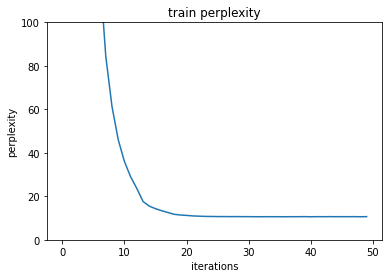

In [19]:
#device = torch.device("cpu")
VOCAB_SIZE = len(encTool.i2w)
learning_rate = 20.0
#モデル生成
print('Build model...')
model = RNNLM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)
#optimizer = optim.Adam(model.parameters(),
#                       lr=0.001,
#                       betas=(0.9, 0.999), amsgrad=True)
hist = {'train_loss': [], 'ppl':[]}

def train_step(x, t, hidden1, hidden2):
    optimizer.zero_grad() #勾配が累積されるのを防ぐ
    preds, hidden1, hidden2 = model(x, hidden1, hidden2)
    # 損失計算
    loss = criterion(preds.view(-1, VOCAB_SIZE), t.view(-1))
    loss.backward()
    #勾配クリッピング
    nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    optimizer.step() #パラメータ更新
    # 隠れ状態の計算グラフを消去
    hidden1 = tuple(h.detach() for h in hidden1)
    hidden2 = tuple(h.detach() for h in hidden2)

    return loss, preds

def eval_perplexity(model, iterator):
    total_loss = 0
    hidden1, hidden2 = None, None
    model.eval()
    with torch.no_grad():
      for input, target in iterator:
        output, hidden1, hidden2 = model(input, hidden1, hidden2)
        loss = F.cross_entropy(output.view(-1, VOCAB_SIZE), target.view(-1))
        total_loss += loss.item()
    
    ppl = math.exp(total_loss / len(iterator))
    return ppl

best_ppl = float('inf')
ppl_list = []
for epoch in tqdm(range(epochs)):
    model.train() #モデルを訓練モードに
    train_loss = 0.
    loss_count = 0
    hidden1, hidden2 = None, None
    for i, iters in enumerate(train_iter):
        x, t = iters
        x, t = x.to(device), t.to(device)
        optimizer.zero_grad() #勾配が累積されるのを防ぐ
        preds, hidden1, hidden2 = model(x, hidden1, hidden2)
        #  損失計算
        loss = criterion(preds.view(-1, VOCAB_SIZE), t.view(-1))
        loss.backward()
        #勾配クリッピング
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step() #パラメータ更新
        # 隠れ状態の計算グラフを消去
        hidden1 = tuple(h.detach() for h in hidden1)
        hidden2 = tuple(h.detach() for h in hidden2)
        train_loss += loss.item()
        loss_count += 1
    # perplexity
    ppl = np.exp(train_loss / loss_count)    
    ppl_list.append(ppl)
    #出力を見る
    
    # 検証データで評価
    val_ppl = eval_perplexity(model, val_iter)
    print(f'| epoch {epoch+1} : valid perplexity {val_ppl:.2f} |')
    if val_ppl < best_ppl:
      best_ppl = val_ppl
      model_name = OUTPUT_MODEL_DIR + "batch{}_bptt{}_hid{}_emb{}_epoch{}.pt".format(BATCH_SIZE, BPTT_LEN, HIDDEN_DIM, EMBEDDING_DIM, epoch)
      torch.save(model.state_dict(), model_name)
    else:
      learning_rate /= 4.0
      for group in optimizer.param_groups:
        group['lr'] = learning_rate

torch.save(model.state_dict(), OUTPUT_MODEL_DIR+"batch{}_bptt{}_hid{}_emb{}_epoch{}.pt".format(BATCH_SIZE, BPTT_LEN, HIDDEN_DIM, EMBEDDING_DIM, epoch))

#perplexity の確認
plt.plot(ppl_list)
plt.ylim((0, 100))
plt.xlabel('iterations')
plt.ylabel('perplexity')
plt.title('train perplexity')
plt.show()